<a href="https://colab.research.google.com/github/priyanka-moorthy/nuclie/blob/master/Models/Nuclei_Mask_RCNN_config1/Nuclei_mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import statements
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

In [2]:
#upload files to colab
from google.colab import files
uploaded_file = files.upload()


Saving nucliedata.zip to nucliedata.zip


In [3]:
#unzip to folder named images 
import zipfile
import tarfile
zip_ref = zipfile.ZipFile('nucliedata.zip','r')
zip_ref.extractall('images')
zip_ref.close()

'''if (fname.endswith("tar.gz")):
    tar = tarfile.open('nuclei_datasets.tar.gz', "r:gz")
    tar.extractall()
    tar.close()
elif (fname.endswith("tar")):
    tar = tarfile.open('nuclei_datasets.tar.gz', "r:")
    tar.extractall()
    tar.close()'''

'if (fname.endswith("tar.gz")):\n    tar = tarfile.open(\'nuclei_datasets.tar.gz\', "r:gz")\n    tar.extractall()\n    tar.close()\nelif (fname.endswith("tar")):\n    tar = tarfile.open(\'nuclei_datasets.tar.gz\', "r:")\n    tar.extractall()\n    tar.close()'

In [0]:
# Data Path
TRAIN_PATH = 'images/nucliedata/stage1_train/'
TEST_PATH = 'images/nucliedata/stage1_test/'

In [0]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [6]:
#upload required congig,utils,model and visualize files
print("Please upload the config.py")
from google.colab import files
src = list(files.upload().values())[0]
open('config.py','wb').write(src)
import config

print("Please upload the utils.py ")
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils

print("Please upload the model.py")
from google.colab import files
src = list(files.upload().values())[0]
open('model.py','wb').write(src)
import model

print("Please upload the visualize.py")
from google.colab import files
src = list(files.upload().values())[0]
open('visualize.py','wb').write(src)
import visualize

from config import Config
import utils
import model as modellib
import visualize
from model import log

Please upload the config.py


Saving config.py to config.py
Please upload the utils.py 


Saving utils.py to utils.py
Please upload the model.py


Saving model.py to model.py
Please upload the visualize.py


Using TensorFlow backend.


Saving visualize.py to visualize.py


In [0]:
%matplotlib inline 

In [8]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [9]:
class NucleiConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 896
    IMAGE_MAX_DIM = 896

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 800

    # set number of epoch
    STEPS_PER_EPOCH = 200

    # set validation steps 
    VALIDATION_STEPS = 50
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[224 224]
 [112 112]
 [ 56  56]
 [ 28  28]
 [ 14  14]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  896
IMAGE_MIN_DIM                  896
IMAGE_PADDING                  True
IMAGE_SHAPE                    [896 896   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE  

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
class NucleiDataset(utils.Dataset):
    
    def load_shapes(self, mode):
        
        # Add classes
        self.add_class("shapes", 1, "nucleus")
        

        if mode == "train":  
            for n, id_ in enumerate(train_ids):
                if n < int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)
              
        if mode == "val":   
            for n, id_ in enumerate(train_ids):
                if n >= int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)      

    def load_image(self, image_id):
        
        info = self.image_info[image_id]
        info = info.get("id")
       
        path = TRAIN_PATH + info
        img = imread(path + '/images/' + info + '.png')[:,:,:3]
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
       
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")
        path = TRAIN_PATH + info
        number_of_masks = len(next(os.walk(path + '/masks/'))[2])
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], number_of_masks], dtype=np.uint8)
        iterator = 0
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = resize(mask_, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
            mask[:, :, iterator] = mask_
            iterator += 1
            # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
        # Map class names to class IDs.
        class_ids = np.ones((number_of_masks,), dtype=int)
        
        return mask, class_ids.astype(np.int32)
         
       
        

In [0]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()

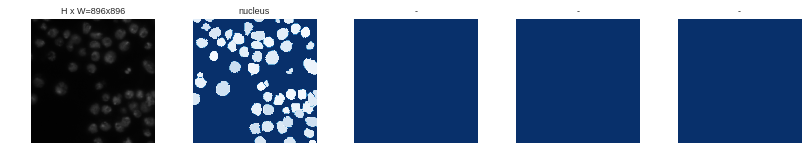

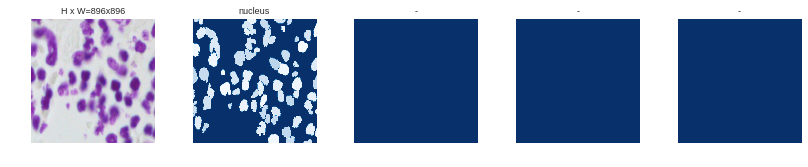

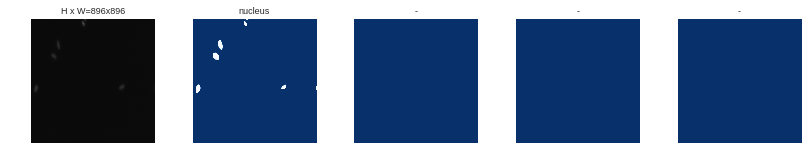

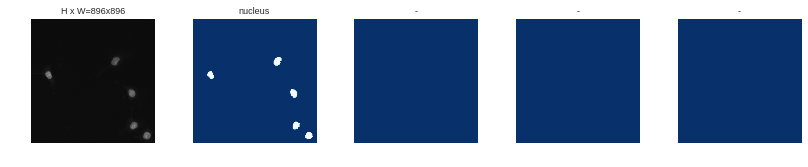

In [13]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [0]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [0]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [16]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/nuclei20181202T1625/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
200/200 [==============================] - 769s 4s/step - loss: 1.4034 - rpn_class_loss: 0.1411 - rpn_bbox_loss: 0.5464 - mrcnn_class_loss: 0.1320 - mrcnn_bbox_loss: 0.2646 - mrcnn_mask_loss: 0.3191 - val_loss: 1.6674 - val_rpn_class_loss: 0.0656 - val_rpn_bbox_loss: 0.6293 - val_mrcnn_class_loss: 0.3128 - val_mrcnn_bbox_loss: 0.4046 - val_mrcnn_mask_loss: 0.2551


In [0]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_nuclie.h5")
model.keras_model.save_weights(model_path)

In [18]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /content/logs/nuclei20181202T1625/mask_rcnn_nuclei_0001.h5


original_image           shape: (896, 896, 3)         min:   14.91582  max:  217.40561
image_meta               shape: (10,)                 min:    0.00000  max:  896.00000
gt_class_id              shape: (29,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (29, 4)               min:    0.00000  max:  896.00000
gt_mask                  shape: (896, 896, 29)        min:    0.00000  max:  255.00000


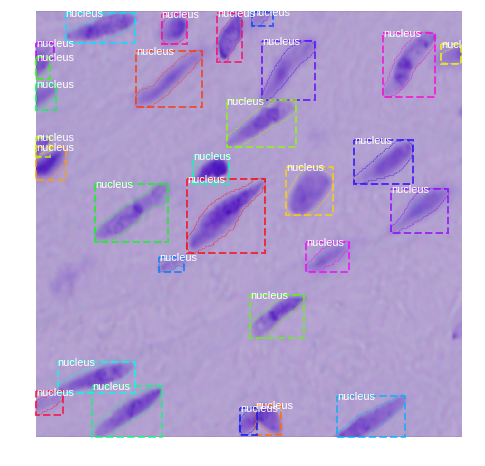

In [19]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (896, 896, 3)         min:   14.91582  max:  217.40561
molded_images            shape: (1, 896, 896, 3)      min: -101.88418  max:  113.50561
image_metas              shape: (1, 10)               min:    0.00000  max:  896.00000


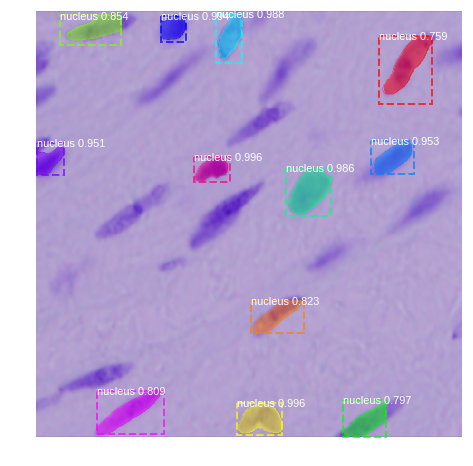

In [20]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [22]:
# Compute VOC-Style mAP @ IoU=0.5

image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.4137931168079376


In [23]:
# Compute VOC-Style mAP @ IoU=0.5
#for train data
image_ids = dataset_train.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.6931243857305263


In [24]:
X_test = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
sizes_test = []
_test_ids = []

print('Getting and resizing test images ... ')
#sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    _test_ids.append([id_])
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


checking a test image with masks ...
Processing 1 images
image                    shape: (896, 896, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 896, 896, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  896.00000


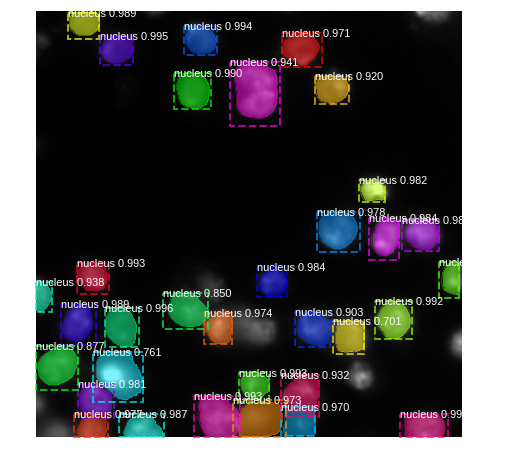

In [25]:
print("checking a test image with masks ...")
results = model.detect([X_test[7]], verbose=1)

r = results[0]
visualize.display_instances(X_test[7], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


In [26]:
image_ids_tst = X_test
APs = []

for i in range(10):
    
    results = model.detect([X_test[i]], verbose=1)
    r = results[0]
    AP, precisions, recalls, overlaps =\
          utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                           r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
  
print("mAP: ", np.mean(APs))

Processing 1 images
image                    shape: (896, 896, 3)         min:    0.00000  max:   80.00000
molded_images            shape: (1, 896, 896, 3)      min: -123.70000  max:  -23.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  896.00000
Processing 1 images
image                    shape: (896, 896, 3)         min:    0.00000  max:  118.00000
molded_images            shape: (1, 896, 896, 3)      min: -123.70000  max:   14.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  896.00000
Processing 1 images
image                    shape: (896, 896, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 896, 896, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  896.00000
Processing 1 images
image                    shape: (896, 896, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 896, 896, 3)  